<a href="https://colab.research.google.com/github/jgabrielsb-sb/DCC_analises/blob/main/dados_antibiotico_cti_mimic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EXAMES CTI
**MIMIC-IV**

---

**ATENÇÃO**

- Para executar esse notebook, você precisa ter acesso às bases do MIMIC-IV no [BigQuery](https://mimic.mit.edu/docs/gettingstarted/cloud/bigquery/).
- Para executar esse notebook local, você precisa instalar o [gcloud-cli](https://cloud.google.com/sdk/docs/install?hl=pt-br) e inicializá-lo.


---





## Carregar pacotes

In [2]:
from google.cloud import bigquery
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

**Rode o código abaixo somente se estiver no colab.**

In [3]:
from google.colab import auth
auth.authenticate_user()

# from google.colab import data_table
# data_table.enable_dataframe_formatter()

## Variáveis globais

* **Importante!** Você precisa modificar o valor da variável projeto para refletir o nome do projeto na sua configuração do Google Cloud. Veja como criar um projeto no Google Cloud [aqui](https://cloud.google.com/resource-manager/docs/creating-managing-projects?hl=pt-br).

In [4]:
projeto = 'mimic-tutorial-391916' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore

dataset_hosp = 'physionet-data.mimiciv_hosp'
dataset_icu = 'physionet-data.mimiciv_icu'
dataset_ed = 'physionet-data.mimiciv_ed'
dataset_note = 'physionet-data.mimiciv_note'
dataset_cxr = 'physionet-data.mimic_cxr'

paciente = 10012853
admissao = 27882036

In [5]:
sql = 'SELECT * FROM `' + dataset_icu + '.' + 'd_items`;'
d_items = pd.read_gbq(sql, projeto)

In [6]:
d_items['category'].unique()

array(['IABP', 'Cardiovascular (Pulses)', 'Skin - Assessment',
       'Case Management', 'ADT', 'OB-GYN', 'ApacheII Parameters',
       'ApacheIV Parameters', 'Tandem Heart', 'Family Mtg Note',
       'Pastoral Care Note', 'NICOM', 'Centrimag', 'Heartware',
       'Swallow Evaluation', 'SBNET', 'Triggers Note', 'RNTriggerNote',
       'Durable VAD', 'RDOS', 'ZIntake', 'PiCCO',
       'Nutrition - Supplements', 'Nutrition - Parenteral', '5-Imaging',
       '1-Intubation/Extubation', '6-Cultures', '2-Ventilation',
       '7-Communication', 'Ingredients', 'Research Enrollment Note',
       'ECMO', 'Labs', 'GI/GU', 'Alarms', 'Drains', 'Output', 'General',
       'Impella', 'Dialysis', 'OT Notes', 'Pulmonary', 'Care Plans',
       'Intubation', 'Toxicology', 'Treatments', 'Antibiotics',
       'Medications', 'Respiratory', '4-Procedures', 'Bronchoscopy',
       'Hemodynamics', 'Neurological', 'Paracentesis', 'CVL Insertion',
       'Fluids/Intake', 'Pain/Sedation', 'Thoracentesis',
       '

In [7]:
d_items.loc[d_items['abbreviation'].str.contains('CRP'), :]

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
371,220612,ZC Reactive Protein (CRP),ZC Reaction Protein (CRP),chartevents,Labs,None,Numeric,NaN,NaN
476,227444,C Reactive Protein (CRP),C Reactive Protein (CRP),chartevents,Labs,None,Numeric with tag,NaN,NaN


In [8]:
crp_ids = d_items.loc[d_items['abbreviation'].str.contains('CRP'), 'itemid']

In [9]:
sql = 'SELECT * FROM `' + dataset_icu + '.' + 'chartevents` '
sql += 'WHERE ' + 'itemid ' + 'IN (' + ','.join(map(str, crp_ids)) +');'
chartevents_crp = pd.read_gbq(sql, projeto)

In [10]:
chartevents_crp.shape

(2749, 11)



*   O paciente recebeu antibiótico na UTI? Qual? Por quanto tempo?
*   Analisar a frequência da medição do PCR por paciente.
*   Identificar as outras variáveis usadas no artigo.
*   Verificar tabela procedureevents.


In [11]:
sql = 'SELECT * FROM `' + dataset_icu + '.' + 'procedureevents` '
procedure_crp = pd.read_gbq(sql, projeto)

In [12]:
procedure_crp.head()

,subject_id,hadm_id,stay_id,caregiver_id,starttime,endtime,storetime,itemid,value,valueuom,location,locationcategory,orderid,linkorderid,ordercategoryname,ordercategorydescription,patientweight,isopenbag,continueinnextdept,statusdescription,ORIGINALAMOUNT,ORIGINALRATE
0,10001884,26184834,37510196,42150,2131-01-11 04:40:00,2131-01-12 17:40:00,2131-01-12 17:49:00,225792,2220.0,min,None,None,3830120,3830120,Ventilation,ContinuousProcess,65.0,1,0,FinishedRunning,2220.0,1.0
1,10001884,26184834,37510196,91332,2131-01-13 04:00:00,2131-01-19 17:45:00,2131-01-19 18:44:00,225792,9465.0,min,None,None,4465887,4465887,Ventilation,ContinuousProcess,65.0,1,0,FinishedRunning,9465.0,1.0
2,10001884,26184834,37510196,91332,2131-01-15 04:07:00,2131-01-19 17:43:00,2131-01-19 18:44:00,225792,6576.0,min,None,None,1861924,1861924,Ventilation,ContinuousProcess,65.0,1,0,FinishedRunning,6576.0,1.0
3,10002013,23581541,39060235,27479,2160-05-18 14:19:00,2160-05-18 18:01:00,2160-05-18 18:39:00,225792,222.0,min,None,None,4169380,4169380,Ventilation,ContinuousProcess,96.0,1,0,FinishedRunning,222.0,1.0
4,10002428,23473524,35479615,27479,2156-05-11 16:05:00,2156-05-20 10:45:00,2156-05-20 10:51:00,225792,12640.0,min,None,None,3976442,3976442,Ventilation,ContinuousProcess,48.4,1,0,FinishedRunning,12640.0,1.0


In [13]:
procedure_crp['itemid'].unique()

<IntegerArray>
[225792, 225794, 229380, 224263, 224264, 225802, 224267, 224268, 224269,
 225805,
 ...
 229585, 229586, 225752, 227550, 227551, 229351, 229614, 229620, 229366,
 225789]
Length: 157, dtype: Int64

In [14]:
crp_events = procedure_crp[procedure_crp['itemid'] == 225792]
crp_events.shape

(30710, 22)

1. Obtendo perfil das medições de CRP

In [15]:
chartevents_crp

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
0,12447048,25229724,38941059,<NA>,2124-01-19 02:56:00,2124-01-19 11:26:00,227444,60.8,60.80,mg/L,1
1,18881392,26218101,38874344,<NA>,2126-08-22 04:00:00,2126-08-22 05:03:00,227444,243,243.00,mg/L,1
2,19614462,28529212,39518615,<NA>,2113-10-05 21:20:00,2113-10-06 00:58:00,227444,16.9,16.90,mg/L,1
3,15729214,22363403,35890951,<NA>,2140-11-17 00:52:00,2140-11-17 04:41:00,227444,2.4,2.40,mg/L,0
4,13594409,26447342,31614327,<NA>,2163-11-26 05:03:00,2163-11-26 13:56:00,227444,30.3,30.30,mg/L,1
5,12683708,21365607,39160004,<NA>,2124-09-20 21:22:00,2124-09-21 02:38:00,227444,169.4,169.40,mg/L,1
6,10483660,27610847,36448639,<NA>,2168-09-11 17:32:00,2168-09-12 02:36:00,227444,211.3,211.30,mg/L,1
7,16304286,23490839,30986145,<NA>,2126-07-05 16:30:00,2126-07-05 19:11:00,227444,34,34.00,mg/L,1
8,19043685,28705333,34685353,<NA>,2185-11-27 20:15:00,2185-11-27 23:16:00,227444,280.8,280.80,mg/L,1
9,19477649,28971647,30540516,<NA>,2168-08-10 17:51:00,2168-08-10 19:13:00,227444,205.1,205.10,mg/L,1


Interpretação do gráfico: foram feitas apenas 2 medições de CRP em cerca de 250 pacientes


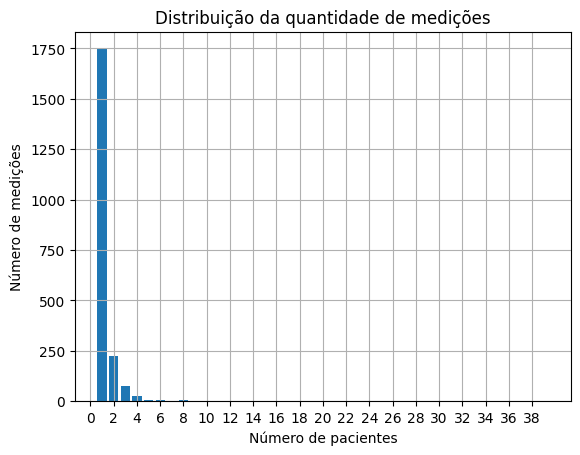

In [16]:
counts = chartevents_crp['subject_id'].value_counts()
frequencia = pd.DataFrame(counts.value_counts().sort_index())
frequencia.reset_index(inplace=True)
frequencia.columns = ['Número de medições', 'Número de pacientes']
frequencia.head()
plt.bar(frequencia['Número de medições'], frequencia['Número de pacientes'])

print("Interpretação do gráfico: foram feitas apenas 2 medições de CRP em cerca de 250 pacientes")
plt.title("Distribuição da quantidade de medições")
plt.xticks(np.arange(0,40,2))
plt.xlabel("Número de pacientes")
plt.ylabel("Número de medições")
plt.grid()
plt.show()


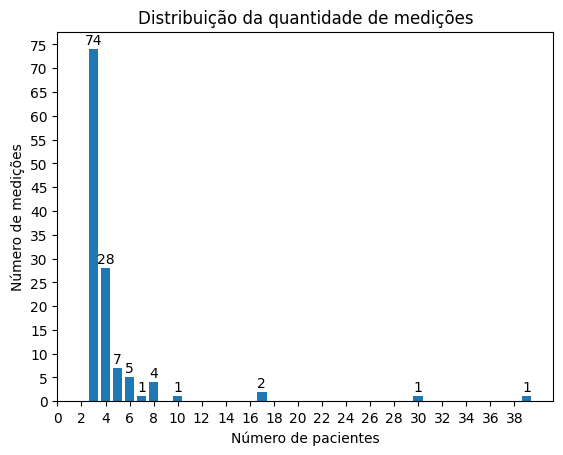

In [17]:
frequencia_corte = frequencia[frequencia['Número de medições'] > 2].reset_index() #retiramos os pacientes com 1 e 2 medições para melhor visualização

plt.bar(frequencia_corte['Número de medições'], frequencia_corte['Número de pacientes'])

plt.title("Distribuição da quantidade de medições")
plt.xticks(np.arange(0,40,2))

for i in range(frequencia_corte.shape[0]):
  x = frequencia_corte.loc[i, 'Número de medições']
  y = frequencia_corte.loc[i, 'Número de pacientes']
  text = str(y)
  plt.text(x, y + 1, text, ha='center')

plt.yticks(np.arange(0,80,5))
plt.xlabel("Número de pacientes")
plt.ylabel("Número de medições")
plt.show()

In [18]:
for i in np.arange(3,8):
  print("temos {} paciente com mais de {} medições".format(counts[counts > i].index.shape[0], i))



ids_pacientes = counts[counts >= 4].index

temos 50 paciente com mais de 3 medições
temos 22 paciente com mais de 4 medições
temos 15 paciente com mais de 5 medições
temos 10 paciente com mais de 6 medições
temos 9 paciente com mais de 7 medições


In [19]:
chartevents_pacientes = chartevents_crp[chartevents_crp['subject_id'].isin(ids_pacientes)]
pacientes = chartevents_pacientes.groupby('subject_id')
i = 0
for subject_id, paciente in pacientes:
    i += 1
    print(f"subject_id: {subject_id}")
    print(pd.DataFrame(paciente))
    print(i)



subject_id: 10051043
      subject_id   hadm_id   stay_id  caregiver_id           charttime  \
403     10051043  23260768  36748093          <NA> 2192-10-17 01:36:00   
1235    10051043  23260768  36748093          <NA> 2192-10-09 23:37:00   
1643    10051043  26563181  30910332          <NA> 2197-06-22 17:54:00   
2011    10051043  22009252  34618905          <NA> 2196-10-06 07:05:00   
2219    10051043  22009252  34618905          <NA> 2196-10-05 13:15:00   
2535    10051043  22009252  34618905          <NA> 2196-10-06 13:20:00   

               storetime  itemid  value  valuenum valueuom  warning  
403  2192-10-17 04:50:00  227444   21.1      21.1     mg/L        1  
1235 2192-10-10 00:51:00  227444  217.4     217.4     mg/L        1  
1643 2197-06-22 19:51:00  227444   40.7      40.7     mg/L        1  
2011 2196-10-06 11:43:00  227444     44      44.0     mg/L        1  
2219 2196-10-05 17:47:00  227444     43      43.0     mg/L        1  
2535 2196-10-06 16:47:00  227444   53.9 

In [21]:
chartevents_pacientes['subject_id']

1       18881392
9       19477649
10      19449272
11      16045796
16      18552263
19      15287471
26      18809588
45      13865462
54      10950205
109     14454179
114     10776490
125     13231630
132     16900375
134     13454746
135     17038041
137     19477649
138     10950205
140     10950205
148     10950205
167     11133561
189     12543250
196     10304606
202     10776490
207     17651038
219     10950205
224     11247296
225     19075045
250     13303444
251     19075045
261     19477649
262     11247296
275     19075045
289     13303444
298     10950205
299     14411859
310     10950205
311     13454746
315     10776490
323     10950205
327     11326660
328     16045796
336     14738199
337     14798319
355     11247296
369     14454179
374     19477649
380     13865462
387     13303444
396     14723793
398     13036533
403     10051043
407     19477649
419     11247296
421     13454746
433     15607827
438     17038041
446     13454746
459     12468016
461     150225

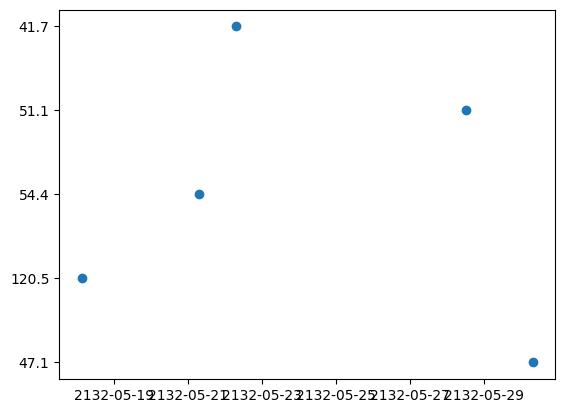

In [25]:
teste = chartevents_pacientes[chartevents_pacientes['subject_id']== 11247296]
plt.scatter(teste['charttime'], teste['value'])


In [26]:
df = []
for id in ids_pacientes:
  paciente_df = 0
  paciente_df = chartevents_crp[chartevents_crp['subject_id'] == id]
  paciente_df = paciente_df.sort_values('charttime')

  paciente_df['diff_time'] = (paciente_df['charttime'] - paciente_df['charttime'].iloc[0]).dt.total_seconds() / (3600*24)
  df.append(paciente_df)

df[3][['charttime','diff_time']]




,charttime,diff_time
2699,2168-07-29 03:47:00,0.000000
2211,2168-07-29 15:01:00,0.468056
2452,2168-07-29 19:08:00,0.639583
2318,2168-07-30 03:57:00,1.006944
1325,2168-07-30 12:13:00,1.351389
798,2168-07-30 21:32:00,1.739583
1454,2168-07-31 04:51:00,2.044444
261,2168-08-09 11:05:00,11.304167
1526,2168-08-09 20:49:00,11.709722
407,2168-08-10 10:29:00,12.279167


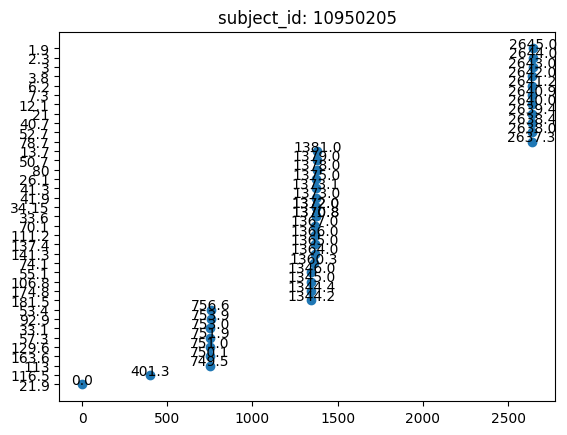

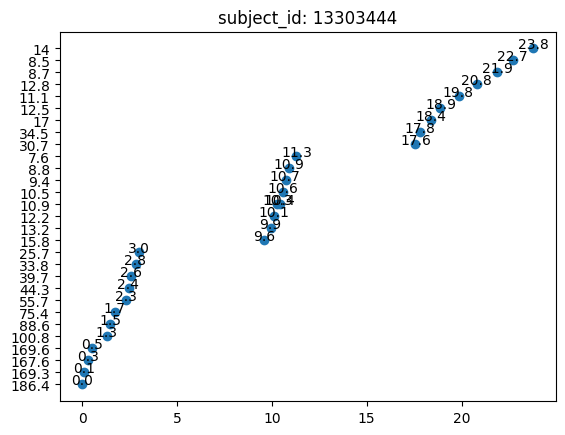

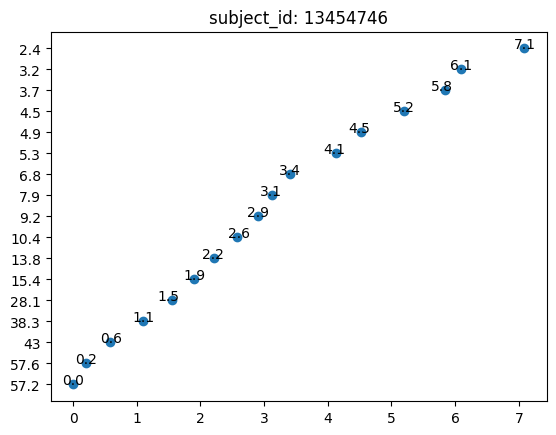

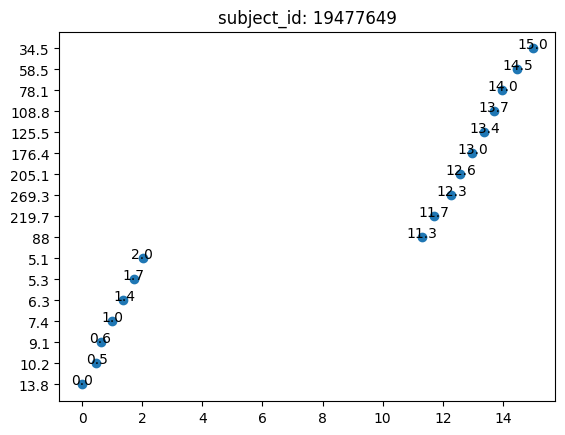

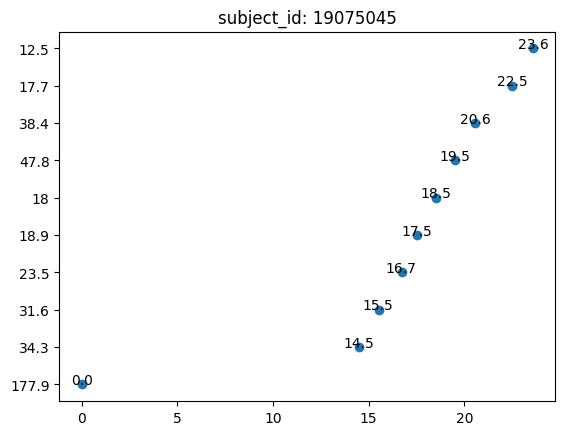

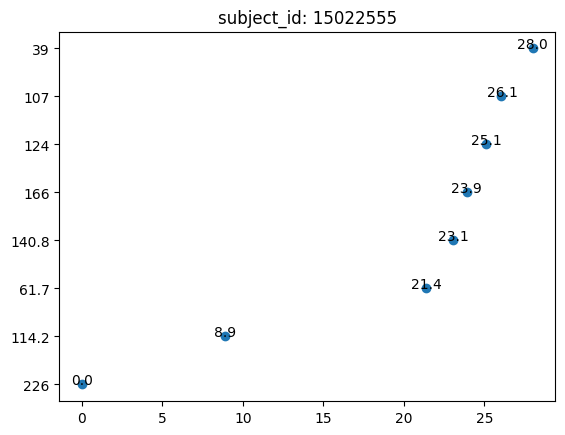

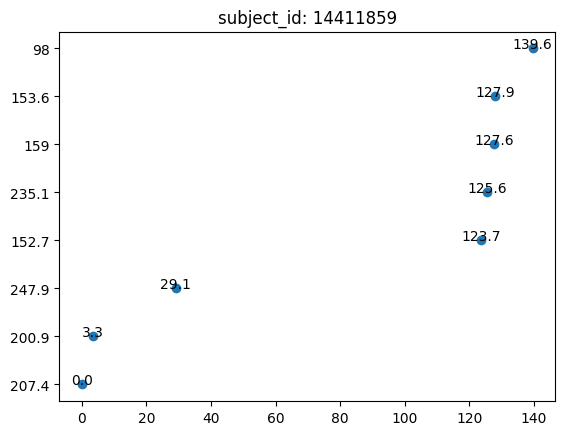

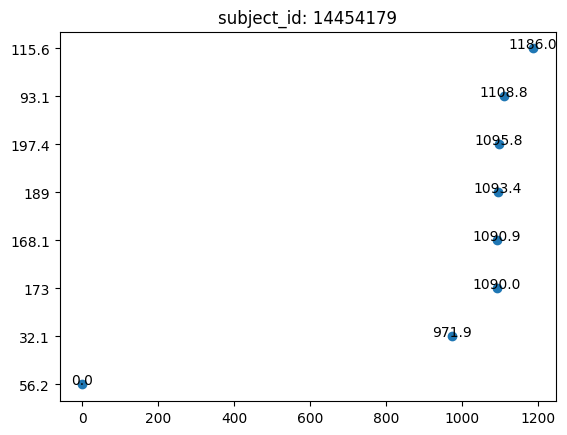

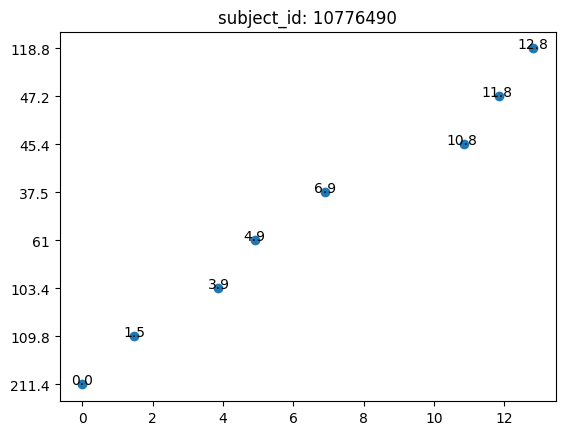

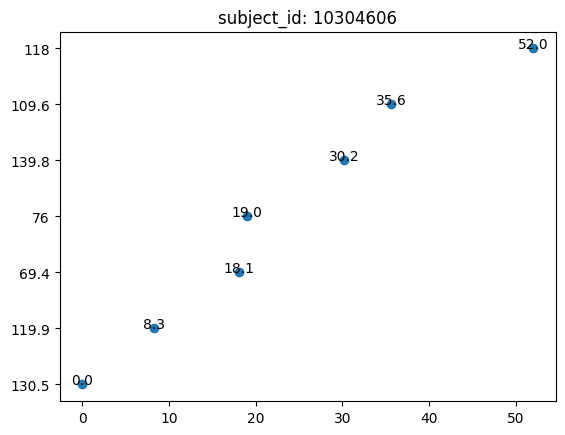

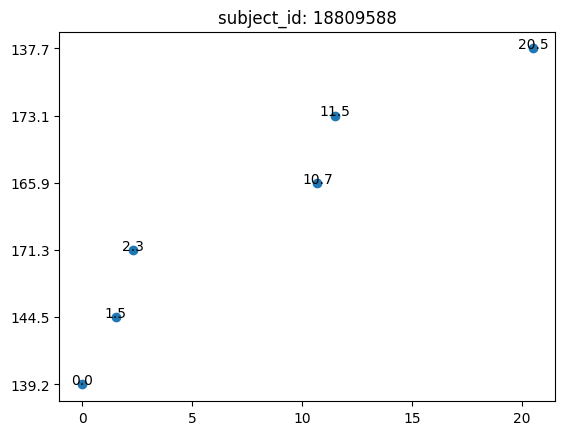

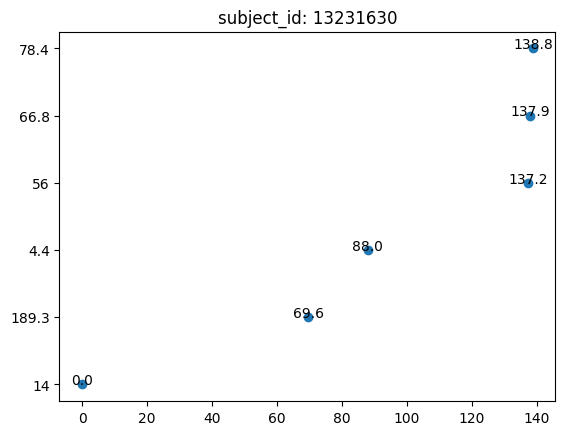

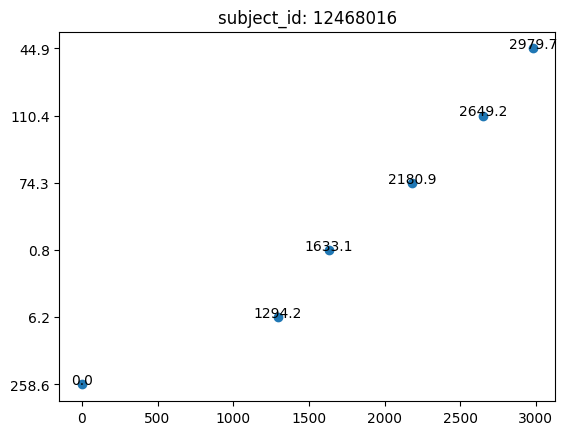

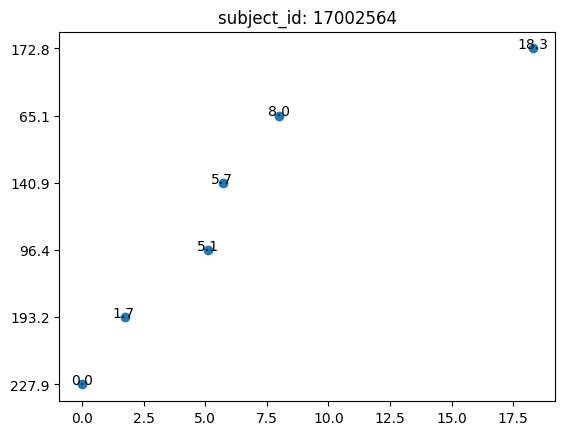

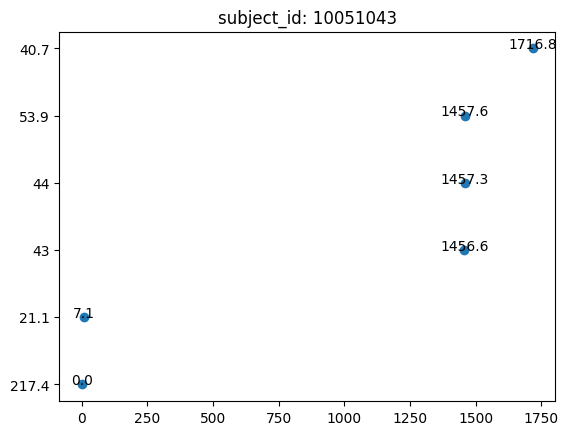

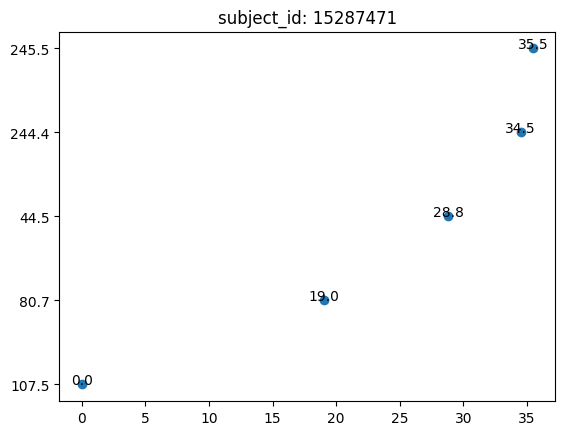

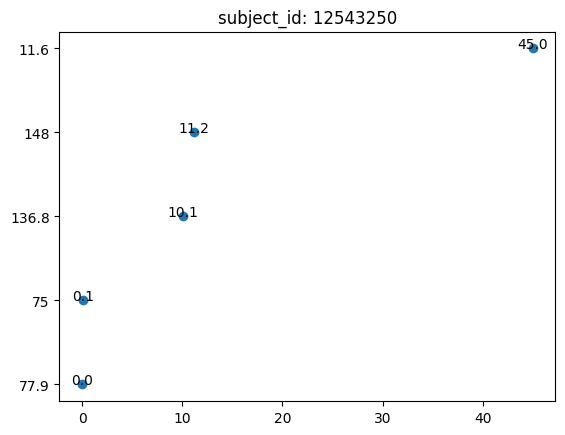

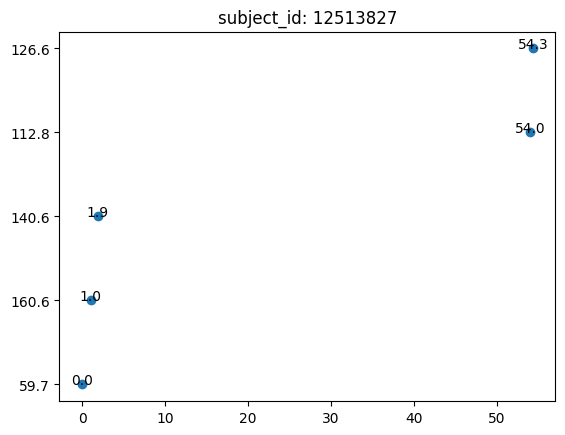

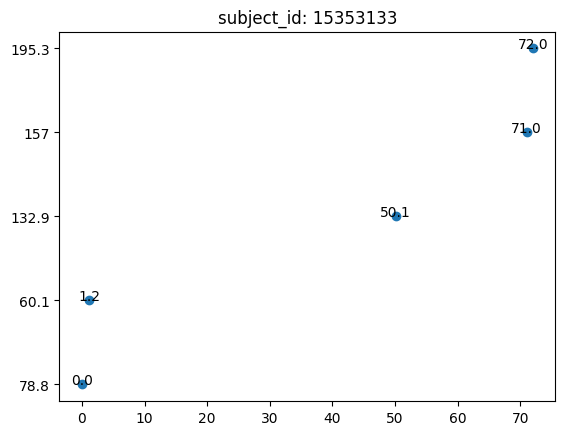

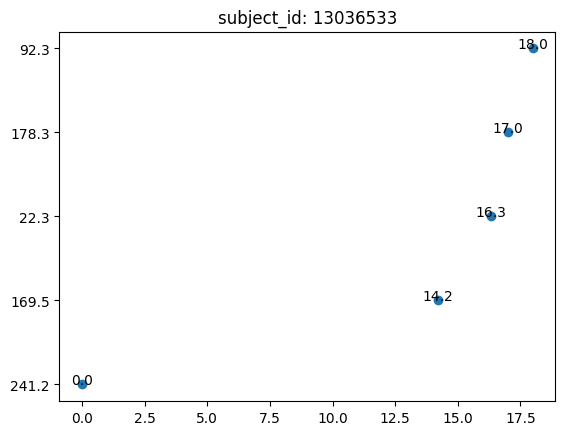

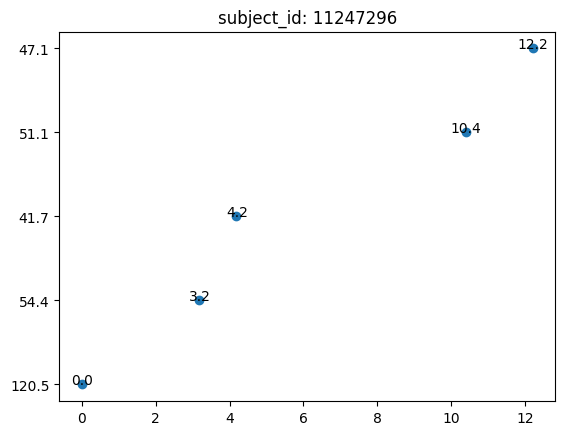

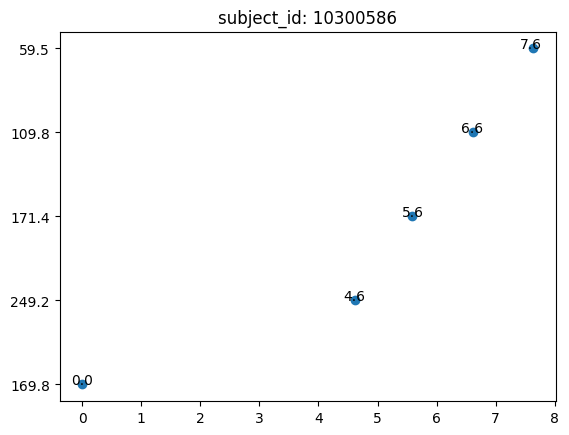

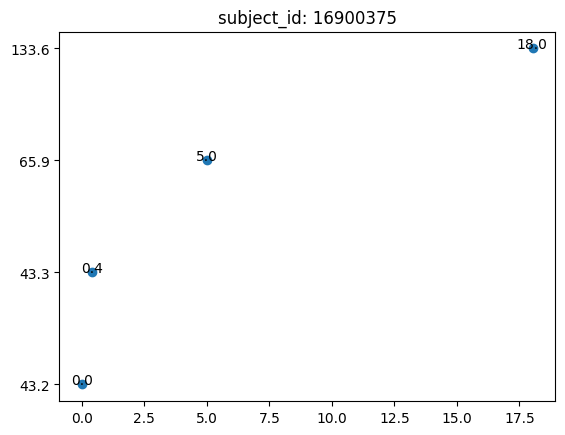

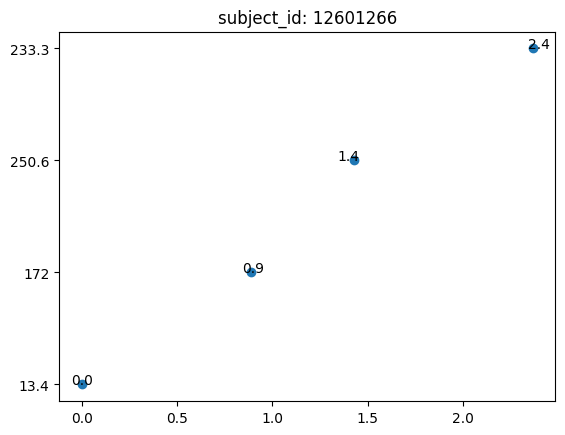

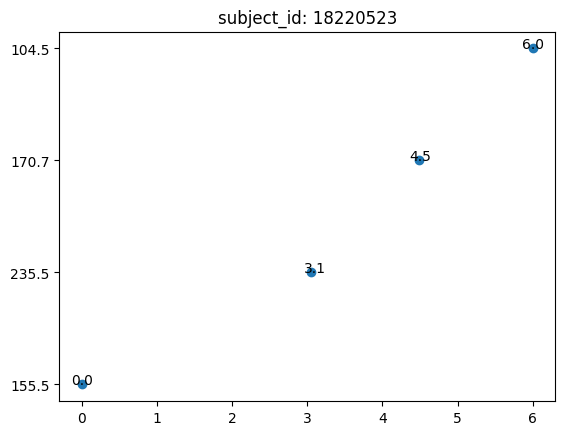

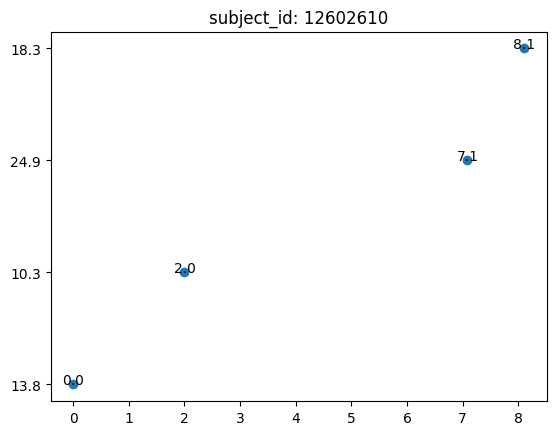

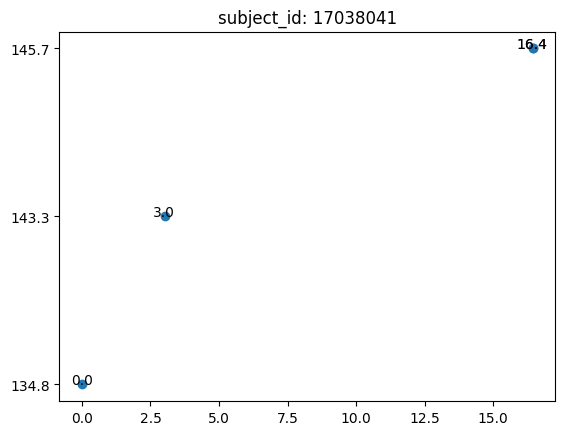

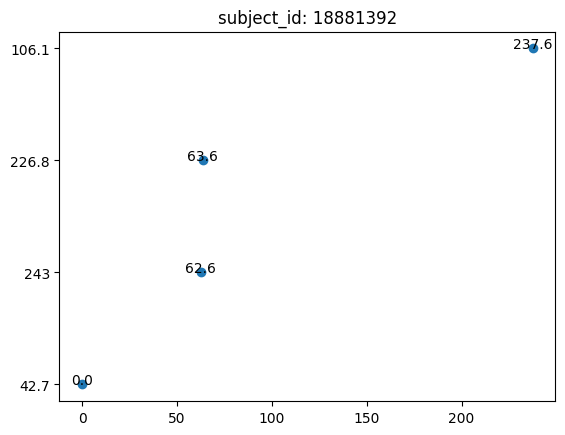

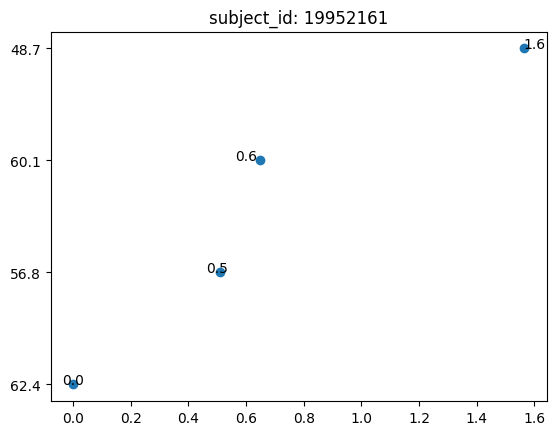

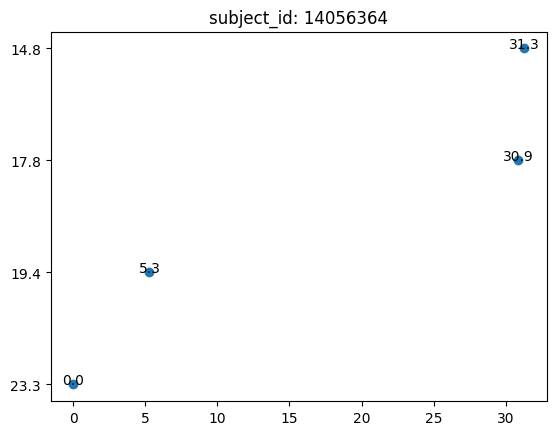

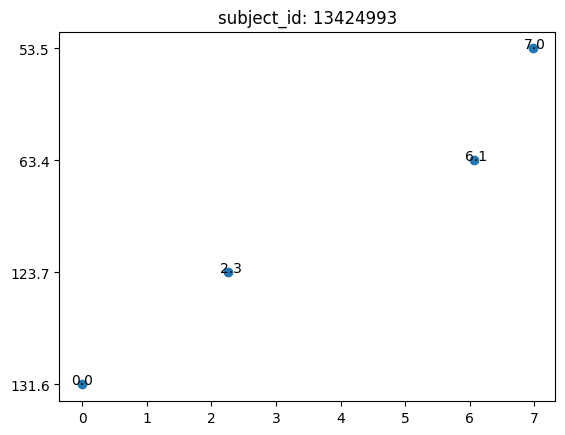

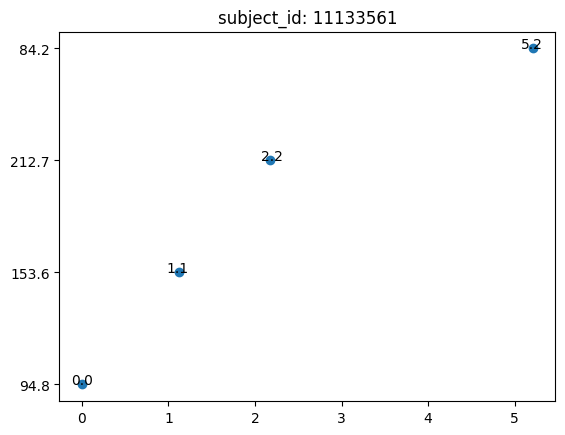

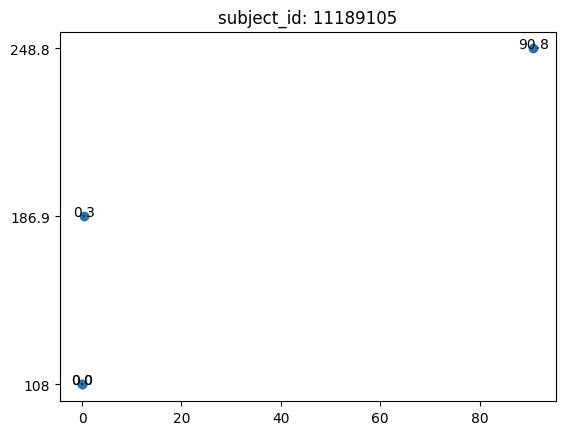

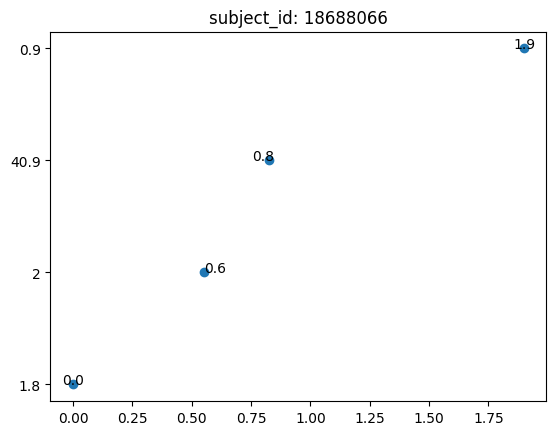

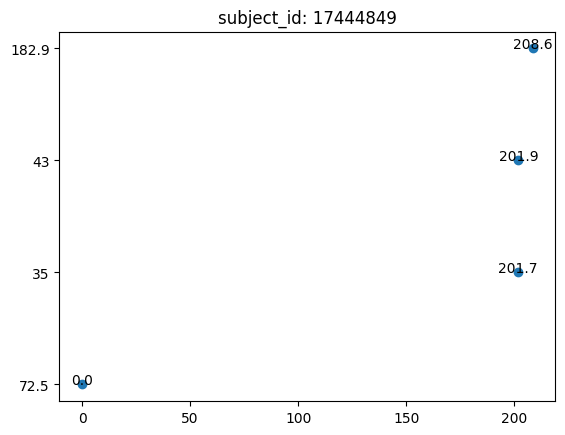

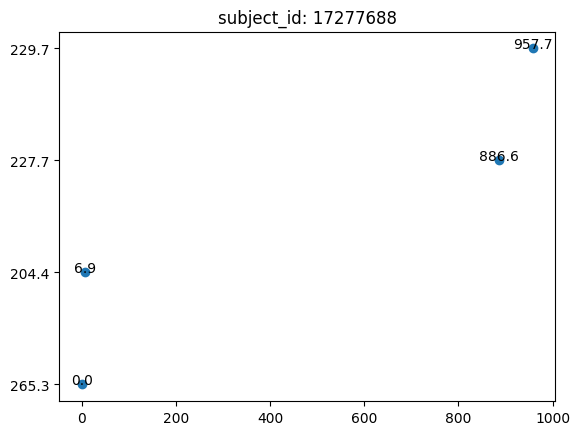

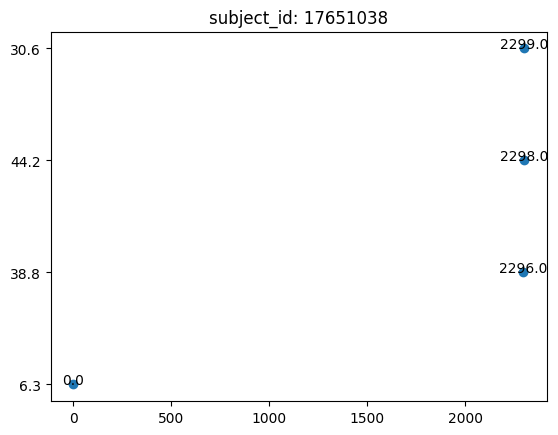

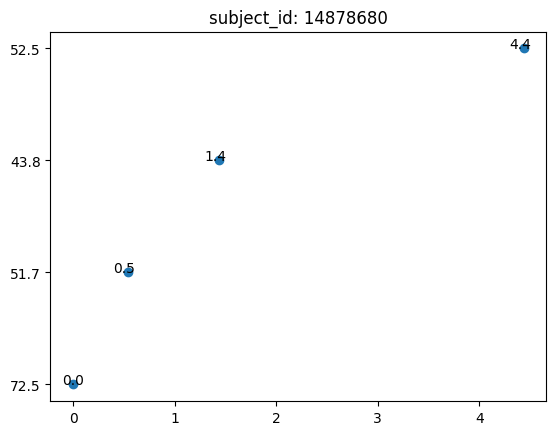

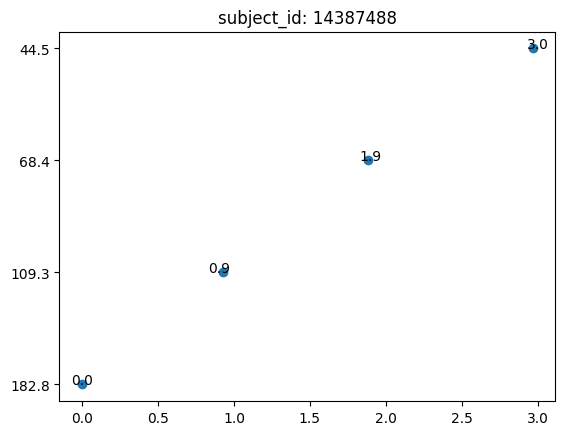

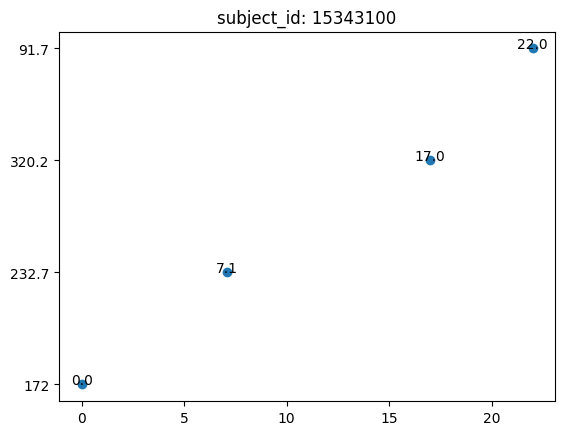

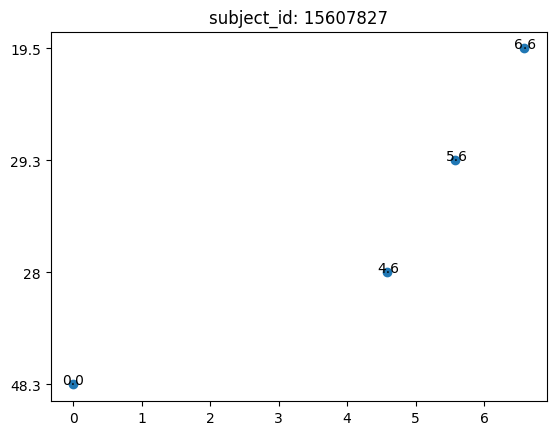

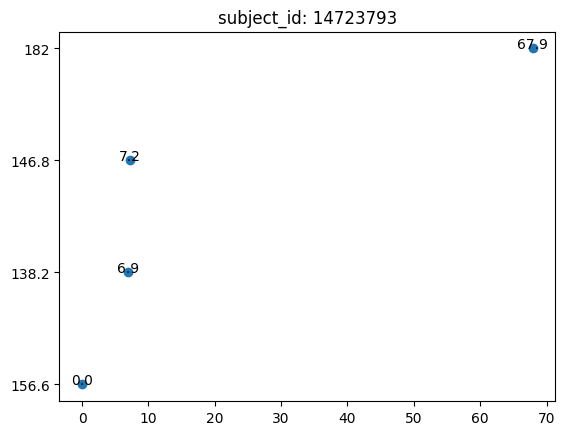

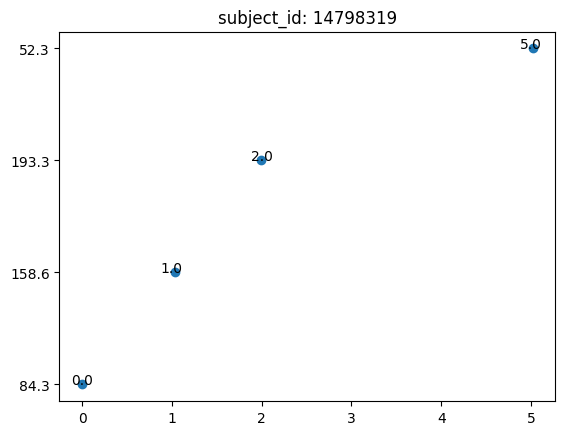

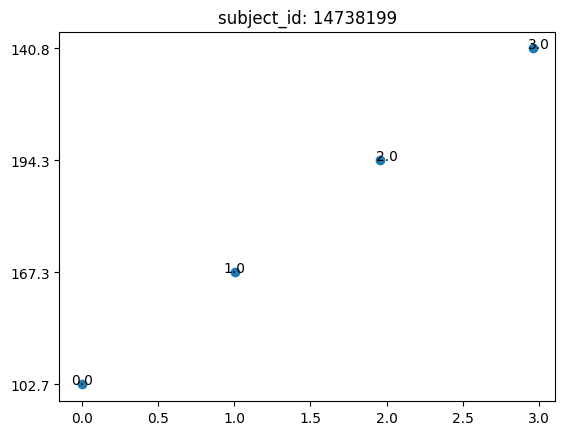

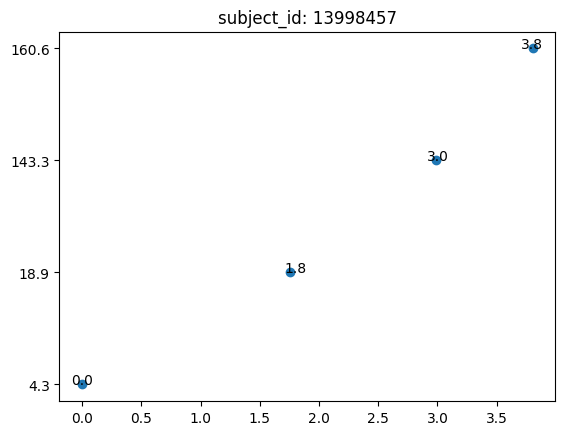

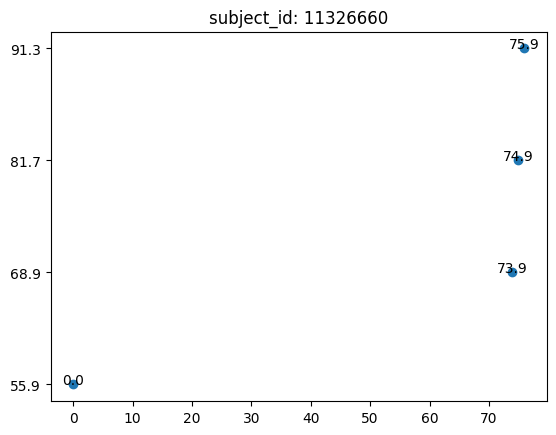

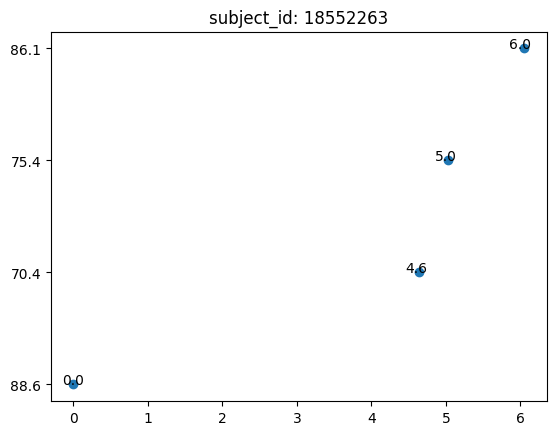

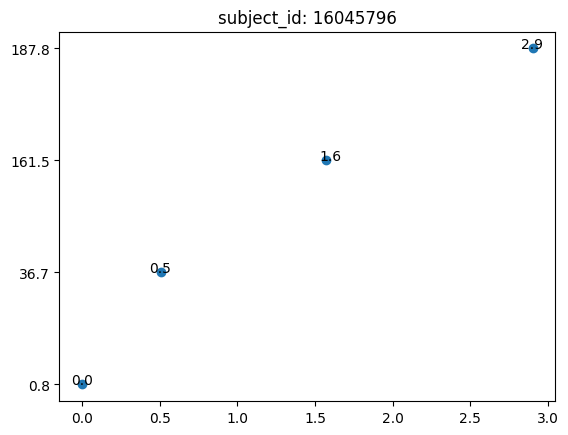

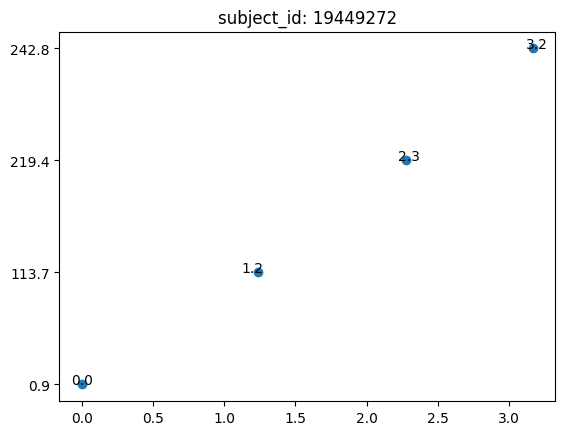

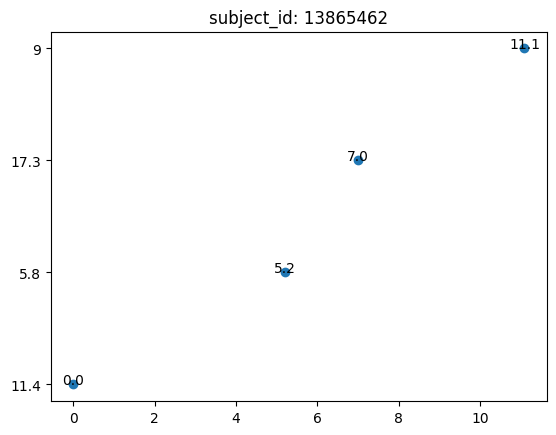

In [29]:
df_interesse = 0

for i in range(len(df)):
  df_interesse = df[i]
  #df_interesse.reset_index(inplace=True)   #retirar comentario na primeira vez que for rodar !!
  plt.scatter(df_interesse['diff_time'], df_interesse['value'])

  for j in range(df_interesse.shape[0]):
    paciente_id = df_interesse.loc[j, 'subject_id']
    x = round(df_interesse.loc[j, 'diff_time'],1)
    y = df_interesse.loc[j, 'value']
    text = str(x)
    plt.text(x, y, text, ha='center')
    plt.title("subject_id: {}".format(paciente_id))

  plt.show()

df_interesse = 0